Importing all the necessary Packages and Library. 
Check out #http://docs.astropy.org/en/stable/table/ for documentation


In [15]:
import numpy as np
import numpy.ma as ma  #For Masking the wrong or null entry and avoiding them in array calculations later on
import matplotlib.pylab as plt
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table,join 

import matplotlib.patches as mpatches
from astropy.cosmology import WMAP9
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import matplotlib.patheffects as PathEffects
from astropy import constants
from matplotlib.patches import Rectangle
from matplotlib import colors
%matplotlib inline

In [16]:
data_location='/Users/qe5106hi/Dropbox/ASTROPHYSICS/oiii_nii_ff_metallicity.csv'
data_table = ascii.read(data_location,data_start=2) #Takes the data from second Row. To avoid the Metadata we 

Looking at the data type for all the variables. Glance at the data Astropy's ascii.read methods returns table object. To know more about the Table object refer to http://docs.astropy.org/en/stable/table/index.html#astropy-table

In [17]:
data_table.info()
print(data_table)

<Table masked=True length=36>
               name                 dtype  n_bad
---------------------------------- ------- -----
                              Name   str12     0
                         Reference   str19     0
                               CII float64     0
                            errCII float64     0
                             ulCII   int64     1
                             OI145 float64     3
                          errOI145 float64     3
                           ulOI145   int64     1
                              N122 float64     0
                           errN122 float64     5
                            ulN122   int64     1
                            OIII88 float64     0
                         errOIII88 float64     0
                          ulOIII88   int64     0
                              OI63 float64     0
                           errOI63 float64     0
                            ulOI63   int64     0
                            NIII57   in

Astronomical Calculations need to be precise with Unit and conversions.Following code is to transform the columns. 

In [18]:
col_list = data_table.colnames
for index,col in enumerate(col_list): #Just to quickly look what variables are in which columns. 
    print(index,col)

0 Name
1 Reference
2 CII
3 errCII
4 ulCII
5 OI145
6 errOI145
7 ulOI145
8 N122
9 errN122
10 ulN122
11 OIII88
12 errOIII88
13 ulOIII88
14 OI63
15 errOI63
16 ulOI63
17 NIII57
18 errNIII57
19 ulNIII57
20 OIII53
21 errOIII53
22 ulOIII53
23 Dust Correction (see Cormier 2015)
24 Metallicity
25 errMetallicity
26 refMetallicity
27 FreeFree
28 errFreeFree
29 ulFreeFree
30 Frequency
31 refFreeFree
32 AltFreeFree
33 errAltFreeFree
34 AltFrequency
35 refAltFreeFree
36 ulAltFreeFree
37 Distance
38 gff


Units:
heat flux density = Wm^-2
12+log(O/H) =>I found this. Very informative https://astronomy.stackexchange.com/questions/11836/why-you-use-log-to-measure-metallicity-in-galaxies


In [19]:
for column in data_table.columns[2,3,5,6,8,9,11,12,14,15,17,18,20,21]:
    data_table['%s' %column].unit = '1e-18 W m^-2' 
for column in data_table.columns[24,25]:
    data_table['%s' %column].unit='12+log(O/H)'
for column in data_table.columns[27,28,32,33]:
    data_table['%s' %column].unit='mJy'
for column in data_table.columns[30,34]:
    data_table['%s' %column].unit='GHz'
data_table.columns[30,34].unit = 'GHz'
data_table.columns[37].unit = 'Mpc'

Masking helps you work with the data you don't need for the computation. 

In [20]:
def make_masked_quantities(data_table,convert_unit=False,desired_unit=None):
    #print unit
    if convert_unit == False:
        values = (data_table.data.data.astype(np.float)*data_table.unit)
    else:
        values = (data_table.data.data.astype(np.float)*data_table.unit).to(desired_unit)
    mask = data_table.mask
    return ma.array(values,mask=mask)

In [21]:
def linear_to_log_errors(data_table,linear_errors): #Function to return the error
    upper_bound = data_table+linear_errors #bound 1st(log,error,direction)
    lower_bound = data_table-linear_errors #bound 1st(log,error,direction)
    log_data = np.log10(data_table)#take_log 1st
    log_upper_bound = np.log10(upper_bound) #take_log 2nd
    log_lower_bound = np.log10(lower_bound) #take_log 3rd
    positive_error = log_upper_bound-log_data #bound 2nd(log,error,direction)
    negative_error = log_data-log_lower_bound #bound 2nd(log,error,direction)
    return positive_error,negative_error
    
def linear_to_log_errors_log_data(log_data_table,linear_errors):
    upper_bound = 10**log_data_table+linear_errors
    lower_bound = 10**log_data_table-linear_errors
    log_data = log_data_table
    log_upper_bound = np.log10(upper_bound)
    log_lower_bound = np.log10(lower_bound)
    positive_error = log_upper_bound-log_data
    negative_error = log_data-log_lower_bound
    return positive_error,negative_error

In [22]:
bounds = lambda data,error: [data+error,data-error]
take_log = lambda x:np.log(x)
log_UL_bounds = take_log(bounds(data_table,errors)) #Gives the Tuple of (Upper error,Lower error)
log_data = take_log(data_table)


NameError: name 'errors' is not defined

In [23]:
#There might be some library for this but i could not find but found this implementation for the same purpose
from functools import reduce
def compose_two(g, f):
    """Function composition for two functions, e.g. compose_two(f, g)(x) == f(g(x))"""
    return lambda *args, **kwargs: g(f(*args, **kwargs))
 
def compose(*funcs):
    """Compose an arbitrary number of functions left-to-right passed as args"""
    return reduce(compose_two, funcs)

composed = compose(bounds,take_log)
composed(5,2)

TypeError: <lambda>() takes 1 positional argument but 2 were given

Now, we can use all the functions we defined for the data we have

In [24]:
#cii = make_masked_quantities(data_table['CII'],True,'W m^-2')
cii_data = make_masked_quantities(data_table['CII'],True,'W m^-2')
ERRcii = make_masked_quantities(data_table['errCII'],True,'W m^-2')
ULcii = np.zeros(len(cii_data))
ULcii[np.where(data_table['ulCII']==1)[0]]= True ##??


#nii = make_masked_quantities(data_table['N122'],True,'W m^-2')
Nii_data = make_masked_quantities(data_table['N122'],True,'W m^-2')
nii_data = make_masked_quantities(data_table['N122'],True,'W m^-2')
ERRnii = make_masked_quantities(data_table['errN122'],True,'W m^-2')
ULnii = np.zeros(len(Nii_data))
ULnii[np.where(data_table['ulN122']==1)[0]]=True

#oiii= make_masked_quantities(data_table['OIII88'],True,'W m^-2')
oiii_data= make_masked_quantities(data_table['OIII88'],True,'W m^-2')
ERRoiii = make_masked_quantities(data_table['errOIII88'],True,'W m^-2')
ULoiii = np.zeros(len(oiii))
ULoiii[np.where(data_table['ulOIII88']==1)[0]]=True #?????????

ff  = make_masked_quantities(data_table['FreeFree'])
ERRff = make_masked_quantities(data_table['errFreeFree'])
#For Free Free values without an uncertainty I assume an error 30% (i.e they are ~3 sigma detections)
ERRff[np.where(data_table['errFreeFree'].data.data==0.)[0]]=0.3*ff[np.where(data_table['errFreeFree'].data.data==0.)[0]].data
ULff = np.zeros(len(ff))
ULff[np.where(data_table['ulFreeFree']==1)[0]]=True

metallicity = ma.array(np.copy(data_table['Metallicity'].data.data),mask=data_table['Metallicity'].data.mask)
ERRmetallicity = data_table['errMetallicity'].data.data
#For the metallicity values without a given uncertainty I give a 0.1 dex error
ERRmetallicity[np.where(data_table['errMetallicity'].data.data<0.1)[0]]=0.1

cloudy_o_solar_abundance = 8.69
cloudy_n_solar_abundance = 7.93
#abundance = metallicity - cloudy_o_solar_abundance
abundance_data = metallicity - cloudy_o_solar_abundance

Plotting the Variables

In [27]:
fig = plt.figure(1,figsize=(4.5,7.5),dpi=150)
fig.subplots_adjust(hspace=0,wspace=0)

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


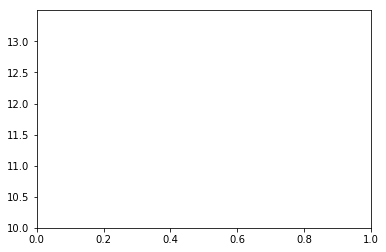

In [28]:
#----------------NII/FF versus Metalicity ------------------------------------#
ax1  = fig.add_subplot(3,1,1)
plt.setp(ax1.get_xticklabels(),visible=False)
#plt.xlim(5e7,1e12)
plt.ylim(10,13.5)
plt.yticks([10.0,10.5,11,11.5,12.0,12.5,13.0])
ydata = ma.array(np.log10((Nii_data/ff).data.value*10.0**29),mask=(Nii_data/ff).mask) #Nii_data?
xdata = metallicity
zdata = ma.array(np.log10((oiii/Nii_data).data.value),mask=(oiii/Nii_data).mask)


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


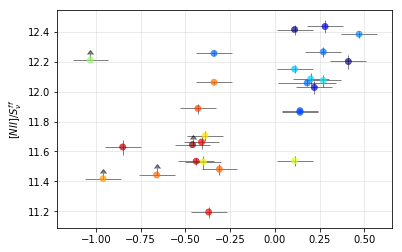

In [30]:
yerr_linear = np.sqrt((ERRnii/Nii_data).data.value**2+(ERRff/ff).data.value**2)*(Nii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULnii

xerr = ERRmetallicity

plt.scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
plt.errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)


plt.ylabel(r'$[NII]/S_{\nu}^{ff}$')
plt.legend()
plt.grid(True,alpha=0.3)



What is (nii/ff).mask doing ?

NameError: name 'cii_data' is not defined

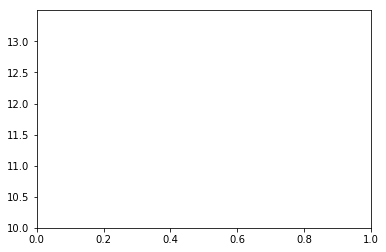

In [12]:
ax3 = fig.add_subplot(3,1,3)
plt.ylim(10,13.5)
plt.yticks([10.0,10.5,11,11.5,12.0,12.5,13.0])

ydata = ma.array(np.log10((cii_data/ff).data.value*10.0**29),mask=(Nii_data/ff).mask)
xdata = metallicity
zdata = ma.array(np.log10((oiii/Nii_data).data.value),mask=(oiii/Nii_data).mask)

yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRff/ff).data.value**2)*(cii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULcii

xerr = ERRmetallicity

plt.scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
plt.errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,
             ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
             
plt.ylabel(r'$[CII]/S_{\nu}^{ff}$')
plt.xlabel(r'$12+log[O/H]$')
plt.grid(True,alpha=0.3)

#cb = plt.colorbar(ax=[ax1,ax2,ax3],orientation="horizontal",fraction=0.04,pad=0.07,
#                  anchor)
CBposition=fig.add_axes([0.35,0.16,0.50,0.02])
cb = plt.colorbar(cax=CBposition,ticks=[0.25,.75,1.25,1.75],orientation="horizontal")
cbax = cb.ax
cbax.text(-0.02,0.4,r'$[OIII]/[NII]$',horizontalalignment='right')
#cb.set_label(r'$[OIII]/[NII]$')

plt.show()



About Mettalicity and Nii and FF lines

NameError: name 'Nii_data' is not defined

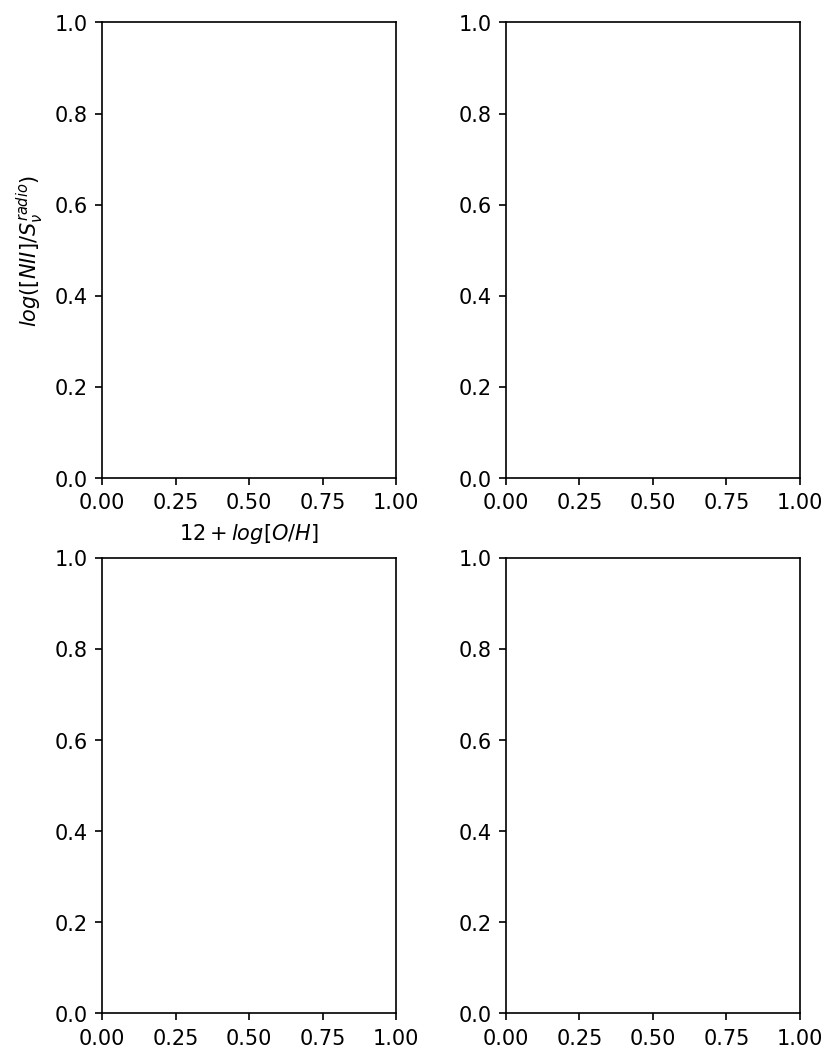

In [11]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(6,8.75),dpi=150)
fig.subplots_adjust(hspace=.175,wspace=.375)
#plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False)

#----------------NII/FF versus Metalicity ------------------------------------#
axes[0,0].set_ylabel(r'$log([NII]/S_{\nu}^{radio})$')
axes[0,0].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(ma.log10((Nii_data/ff).data.value*10.0**29),mask=(Nii_data/ff).mask)
xdata = metallicity
zdata = ma.array(ma.log10((oiii/Nii_data).data.value),mask=(oiii/Nii_data).mask)

#cmap = plt.cm.jet
#norm = colors.Normalize(zdata.min(),zdata.max())
#ec_colors = plt.cm.jet(norm(zdata))


yerr_linear = np.sqrt((ERRnii/Nii_data).data.value**2+(ERRff/ff).data.value**2)*(Nii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yuplims = ULnii
#yerr_log_pos.mask = yuplims
#yerr_log_neg.mask = yuplims
where_UL=np.where(yuplims==1.0)[0]
yerr_log_pos[where_UL]=0

yerr=np.vstack([yerr_log_neg,yerr_log_pos])
#yerr.mask=yuplims
xerr = ERRmetallicity

#--------------oiii---------------#

axes[0,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[0,0].errorbar(xdata,ydata,xerr=xerr,yerr=yerr,lolims=yuplims,ecolor='k',
                   elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)

axes[0,1].set_ylabel(r'$log([OIII]/S_{\nu}^{radio})$')
axes[0,1].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(ma.log10((oiii/ff).data.value*10.0**29),mask=(Nii_data/ff).mask)
xdata = metallicity
zdata = ma.array(ma.log10((oiii/Nii_data).data.value),mask=(oiii/Nii_data).mask)

yerr_linear = np.sqrt((ERRoiii/oiii).data.value**2+(ERRff/ff).data.value**2)*(oiii/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULoiii

xerr = ERRmetallicity

axes[0,1].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
axes[0,1].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
             
#----------------CII/FF versus Metalicity ------------------------------------#
axes[1,0].set_ylabel(r'$log([CII]/S_{\nu}^{radio})$')
axes[1,0].set_xlabel(r'$12+log[O/H]$')

ydata = ma.array(np.log10((cii_data/ff).data.value*10.0**29),mask=(Nii_data/ff).mask)
xdata = metallicity
zdata = ma.array(np.log10((oiii/Nii_data).data.value),mask=(oiii/Nii_data).mask)

yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRff/ff).data.value**2)*(cii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULcii

xerr = ERRmetallicity

cii_plot=axes[1,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
cii_error=axes[1,0].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
             


#cb = plt.colorbar(ax=[ax1,ax2,ax3],orientation="horizontal",fraction=0.04,pad=0.07,
#                  anchor)
CBposition=fig.add_axes([0.15,0.16,0.28,0.0125])
cb = fig.colorbar(cii_plot,cax=CBposition, ticks=[0.25,.75,1.25,1.75,2.25],orientation="horizontal")
cbax = cb.ax
cbax.text(0.0,1.5,r'$[OIII]/[NII]$',horizontalalignment='left')
#cb.set_label(r'$[OIII]/[NII]$')

for ax in axes.flat:
    ax.set_ylim([10.5,13.5])
    ax.set_xlim([7.5,9.5])
    ax.set_yticks([10.5,11,11.5,12.0,12.5,13.0])
    ax.set_xticks([8.0,8.5,9.0,9.5])
    ax.grid(True,alpha=0.3)

#---------------------------------------------------------------------------------------------------------------------


In [10]:



axes[1,0].set_ylabel(r'$log([CII]/S_{\nu}^{radio})$')
axes[1,0].set_xlabel(r'$log(Z/Z_{\odot})$')

ydata = ma.array(np.log10((cii_data/ff).data.value*10.0**29),mask=(Nii_data/ff).mask) #This is causing run time error
xdata = abundance_data
zdata = ma.array(np.log10((oiii/Nii_data).data.value),mask=(oiii/Nii_data).mask)

yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRff/ff).data.value**2)*(cii_data/ff).data.value*10.0**29
yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
yerr_log_pos.mask = ydata.mask
yerr_log_neg.mask = ydata.mask
yuplims = ULcii

xerr = ERRmetallicity

cii_plot=axes[1,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
cii_error=axes[1,0].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
             


#cb = plt.colorbar(ax=[ax1,ax2,ax3],orientation="horizontal",fraction=0.04,pad=0.07,
#                  anchor)
CBposition=fig.add_axes([0.15,0.16,0.28,0.0125])
cb = fig.colorbar(cii_plot,cax=CBposition, ticks=[0.25,.75,1.25,1.75,2.25],orientation="horizontal")
cbax = cb.ax
cbax.text(0.0,1.5,r'$[OIII]/[NII]$',horizontalalignment='left')
#cb.set_label(r'$[OIII]/[NII]$')

for ax in axes.flat:
    ax.set_ylim([10.5,13.5])
    ax.set_xlim([-1.25,0.75])
    ax.set_yticks([10.5,11,11.5,12.0,12.5,13.0])
    ax.set_xticks([-1.0,-0.5,0.0,0.5])
    ax.grid(True,alpha=0.3)

    
plt.show()

NameError: name 'axes' is not defined

### Now plotting data and Cloudy models

In [36]:
#import cloudy data and parse it to be usable

cloudy_models_fits = fits.open('/Users/qe5106hi/Dropbox/ASTROPHYSICS/cloudymodelforcarl.fits')
cloudy_models = cloudy_models_fits[0].data

sed = np.concatenate([cloudy_models[23:27,:,:,:,:],cloudy_models[37:30:-1,:,:,:,:]],axis=0) #SED Stands For?
wavelength = [0.0083,0.0025,0.0060,0.0100,0.6917,0.9993,1.335,2.003,3.432,6.137,20.46]
frequency = 3e10/np.array(wavelength)

lines_IR = cloudy_models[4:12,:,:,:,:] #Taking 4:12 for first dimension and everything for rest?
lines_IR_names = ['[CII] 158', '[OI] 63', '[OI] 145', '[NII] 122', '[NII] 205', '[NIII] 57', '[OIII] 88', '[NII] 52' ]
line_wavelength = [157.6,63.17,145.5,121.7,205.4,57.21,88.33,51.80] #microns
#frequency = 3e10/np.array(wavelength)

hbeta = cloudy_models[13,:,:,:,:]
hbeta_wavelength = 0.4861 #microns

nii_205 = lines_IR[4,:,:,:,:]
nii = lines_IR[3,:,:,:,:]
oiii = lines_IR[6,:,:,:,:]
cii = lines_IR[0,:,:,:,:]
Snu_5ghz = sed[9,:,:,:,:]
Snu_8ghz = sed[8,:,:,:,:]
abundances = cloudy_models[1,0,:,0,0]
stellar_age = cloudy_models[2,:,0,0,0]
densities = cloudy_models[0,0,0,0,:]
ionization_param = cloudy_models[3,0,0,:,0]
nii_5GHz = nii/Snu_5ghz
oiii_5GHz = oiii/Snu_5ghz
cii_5GHz = cii/Snu_5ghz
nii_205_5GHz = nii_205/Snu_5ghz

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


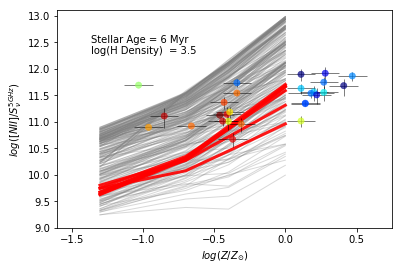

In [37]:
###################
#Plot all models and over plot the observed data              
###################
for key_dens in np.arange(len(densities)):
    for key_age in np.arange(len(stellar_age)):
        #print key_dens, key_age
        fig = plt.figure(1,figsize=(6,4))
        fig.clf()
        ax1 = plt.subplot(111)
        ax1.set_ylabel(r'$log([NII]/S_{\nu}^{5 GHz})$')
        ax1.set_xlabel(r'$log(Z/Z_{\odot})$')
        plt.xlim(-1.6,0.75)
        plt.ylim(9.0,13.1)
        #key_dens = 3 #
        #key_age = 2 #5 mega year
        ax1.annotate("Stellar Age = %i Myr" %stellar_age[key_age],(0.1,0.85),xycoords='axes fraction')
        ax1.annotate(r"log(H Density)  = %.1f" %densities[key_dens],(0.1,0.80),xycoords='axes fraction')
        for dens in  np.arange(len(densities)):
            for age in np.arange(len(stellar_age)):
                for ionization in np.arange(len(ionization_param)):
                    if dens == key_dens and age == key_age:
                        line_color = 'red'
                        alphas = 0.9
                        zorder = -5
                        linewidths = 3
                    else:
                        line_color = 'grey'
                        alphas = 0.3
                        zorder = -10
                        linewidths = 1
                    ax1.plot(np.log10(abundances),np.log10(nii_5GHz[age,:,ionization,dens]*frequency[9]),marker=None,
                               linestyle='-',alpha=alphas,color=line_color,zorder=-10,linewidth=linewidths)
        
        #plot the read data    
        ydata = ma.array(np.log10((nii_data/ff).data.value*10.0**29),mask=(nii_data/ff).mask)
        xdata = abundance_data
        zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=(oiii_data/nii_data).mask)
        
        #cmap = plt.cm.jet
        #norm = colors.Normalize(zdata.min(),zdata.max())
        #ec_colors = plt.cm.jet(norm(zdata))
        
        
        yerr_linear = np.sqrt((ERRnii/nii_data).data.value**2+(ERRff/ff).data.value**2)*(nii_data/ff).data.value*10.0**29
        yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
        yerr_log_pos.mask = ydata.mask
        yerr_log_neg.mask = ydata.mask
        yuplims = ULnii
        
        yerr=np.vstack([yerr_log_neg,yerr_log_pos])
        yerr.mask=yuplims
        xerr = ERRmetallicity
        
        ax1.scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
        ax1.errorbar(xdata,ydata,xerr=xerr,yerr=yerr,lolims=yuplims,
                     ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
#plt.show()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:66: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2818: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)
/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:116: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:157: RuntimeWarning: divide by zero encountered in log10
/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`)

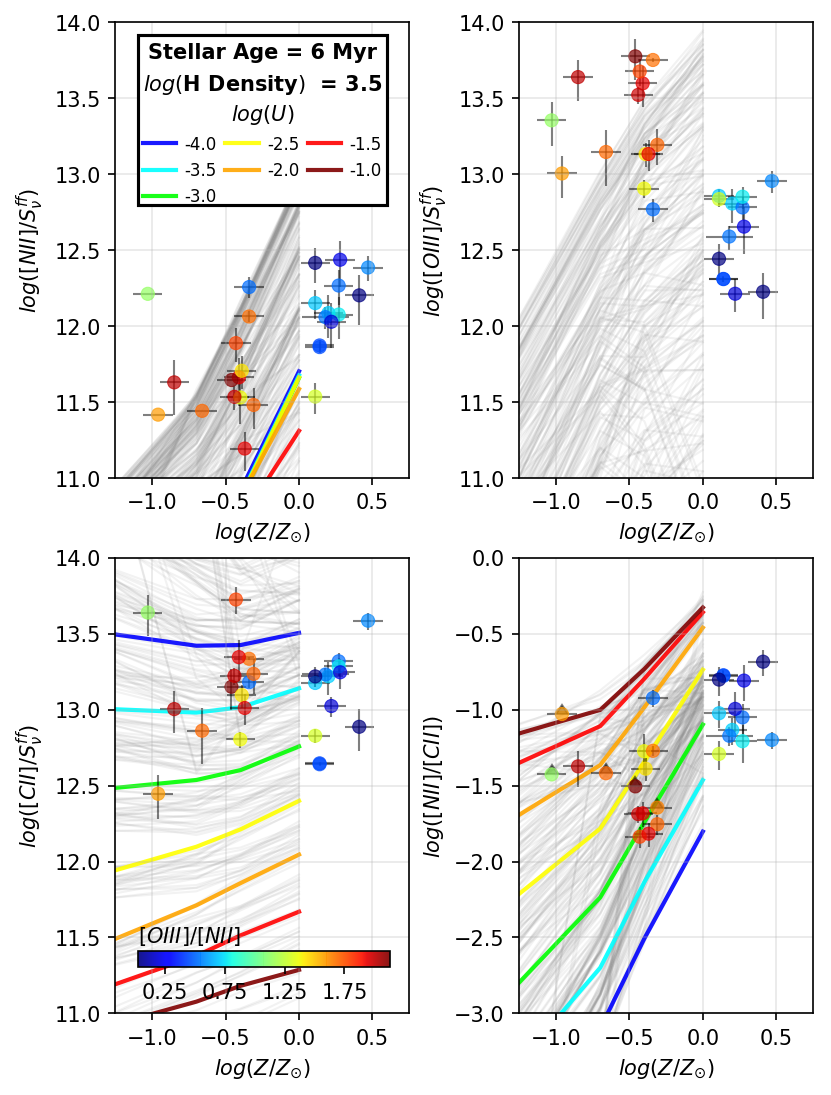

In [41]:
#Plot all models and over plot the observed data   for NII, OIII and CII           
###################
#-----------------------------------------------------------------------------#


#plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False)
#plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False)

from matplotlib.patches import Rectangle


key_color = 'red'
key_alpha = 0.9
key_zorder = -5
key_lindwidths = 2
else_color = 'grey'
else_alpha = 0.1
else_zorder = -10
else_linewidth = 1
ff_fraction = 0.3
#IP_colors = ['maroon','red','orange','yellow','lime','cyan','blue']
IP_colors = ['blue','cyan','lime','yellow','orange','red','maroon']
#for key_dens in np.arange(1):
#    for key_age in np.arange(1):
for key_dens in np.arange(len(densities)):
    for key_age in np.arange(len(stellar_age)):
        fig.clf()
        fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(6,8.75),dpi=150)
        fig.subplots_adjust(hspace=.175,wspace=.375)


#        print key_dens, key_age
#        fig = plt.figure(1,figsize=(6,4))
#        fig.clf()
#        ax1 = plt.subplot(111)
#        ax1.set_ylabel(r'$log([NII]/S_{\nu}^{5 GHz})$')
#        ax1.set_xlabel(r'$log(Z/Z_{\odot})$')
#        plt.xlim(-1.6,0.75)
#        plt.ylim(9.0,13.1)
#----------------NII/FF versus Metalicity ------------------------------------#
        axes[0,0].set_ylabel(r'$log([NII]/S_{\nu}^{ff})$')
        axes[0,0].set_xlabel(r'$log(Z/Z_{\odot})$')
#Models
        axes[0,0].annotate("Stellar Age = %i Myr" %stellar_age[key_age],(0.5,0.92),xycoords='axes fraction',horizontalalignment='center',weight='bold',zorder=10)
        axes[0,0].annotate(r"$log($H Density$)$  = %.1f" %densities[key_dens],(0.5,0.85),xycoords='axes fraction',horizontalalignment='center',weight='bold',zorder=10)
        for dens in  np.arange(len(densities)):
            for age in np.arange(len(stellar_age)):
                for ionization in np.arange(len(ionization_param)):
                    if dens == key_dens and age == key_age:
                        line_color = IP_colors[ionization]
                        alphas = key_alpha
                        zorders = key_zorder
                        linewidths = key_lindwidths
                        labels= "%.1f" %ionization_param[ionization]
                    else:
                        line_color = else_color
                        alphas = else_alpha
                        zorders = else_zorder
                        linewidths = else_linewidth
                        labels=None
                    axes[0,0].plot(np.log10(abundances),np.log10(nii_5GHz[age,:,ionization,dens]*frequency[9]),marker=None,
                               linestyle='-',alpha=alphas,color=line_color,zorder=zorders,linewidth=linewidths,label=labels)
                               

#Data       
        ydata = ma.array(np.log10((Nii_data/ff/ff_fraction).data.value*10.0**29),mask=(Nii_data/ff).mask)
        xdata = abundance_data
        zdata = ma.array(np.log10((oiii_data/Nii_data).data.value),mask=(oiii_data/Nii_data).mask)
        xerr = ERRmetallicity
        
        yerr_linear = np.sqrt((ERRnii/Nii_data).data.value**2+(ERRff/ff).data.value**2)*(Nii_data/ff/ff_fraction).data.value*10.0**29
        yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
        yuplims = ULnii
        #yerr_log_pos.mask = yuplims
        #yerr_log_neg.mask = yuplims
        where_UL=np.where(yuplims==1.0)[0]
        yerr_log_pos[where_UL]=0
        
        axes[0,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
        axes[0,0].errorbar(xdata,ydata,xerr=xerr,yerr=yerr,lolims=yuplims,
                     ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
        l = axes[0,0].legend(loc='upper center',bbox_to_anchor = (0.5,0.86),ncol=3, fontsize = 8,handletextpad=0.5,columnspacing=0.5,
                        borderpad = 0.5, labelspacing = 0.5,frameon=False,title=r'$log(U)$')
        l.set_zorder(10)
        rectangle = Rectangle((-1.1,12.8), 1.7, 1.12, facecolor='white', edgecolor='black',zorder=9,linewidth=1.5)
        axes[0,0].add_artist(rectangle)
        rectangle.set_clip_box(axes[0,0].bbox)

#----------------OIII/FF versus Metalicity ------------------------------------#
#        axes[0,0].annotate("Stellar Age = %i Myr" %stellar_age[key_age],(0.1,0.85),xycoords='axes fraction')
#        axes[0,0].annotate(r"log(H Density)  = %.1f" %densities[key_dens],(0.1,0.80),xycoords='axes fraction')
        axes[0,1].set_ylabel(r'$log([OIII]/S_{\nu}^{ff})$')
        axes[0,1].set_xlabel(r'$log(Z/Z_{\odot})$')
#Models        
        for dens in  np.arange(len(densities)):
            for age in np.arange(len(stellar_age)):
                for ionization in np.arange(len(ionization_param)):
                    if dens == key_dens and age == key_age:
                        line_color = IP_colors[ionization]
                        alphas = key_alpha
                        zorders = key_zorder
                        linewidths = key_lindwidths
                        labels= "%.1f" %ionization_param[ionization]
                    else:
                        line_color = else_color
                        alphas = else_alpha
                        zorders = else_zorder
                        linewidths = else_linewidth
                        labels=None
                    axes[0,1].plot(np.log10(abundances),np.log10(oiii_5GHz[age,:,ionization,dens]*frequency[9]),marker=None,
                               linestyle='-',alpha=alphas,color=line_color,zorder=zorders,linewidth=linewidths,label=labels)
  
#Data        

        
        ydata = ma.array(np.log10((oiii_data/ff/ff_fraction).data.value*10.0**29),mask=(Nii_data/ff).mask)
        xdata = abundance_data
        zdata = ma.array(np.log10((oiii_data/Nii_data).data.value),mask=(oiii_data/Nii_data).mask)
        
        yerr_linear = np.sqrt((ERRoiii/oiii_data).data.value**2+(ERRff/ff).data.value**2)*(oiii_data/ff/ff_fraction).data.value*10.0**29
        yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
        yuplims = ULoiii
        #yerr_log_pos.mask = yuplims
        #yerr_log_neg.mask = yuplims
        where_UL=np.where(yuplims==1.0)[0]
        yerr_log_pos[where_UL]=0        
        xerr = ERRmetallicity
        
        axes[0,1].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
        axes[0,1].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,
                     ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)

        

#----------------CII/FF versus Metalicity ------------------------------------#
        axes[1,0].set_ylabel(r'$log([CII]/S_{\nu}^{ff})$')
        axes[1,0].set_xlabel(r'$log(Z/Z_{\odot})$')
#Models        
        for dens in  np.arange(len(densities)):
            for age in np.arange(len(stellar_age)):
                for ionization in np.arange(len(ionization_param)):
                    if dens == key_dens and age == key_age:
                        line_color = IP_colors[ionization]
                        alphas = key_alpha
                        zorders = key_zorder
                        linewidths = key_lindwidths
                        labels= "%.1f" %ionization_param[ionization]
                    else:
                        line_color = else_color
                        alphas = else_alpha
                        zorders = else_zorder
                        linewidths = else_linewidth
                        labels=None
                    axes[1,0].plot(np.log10(abundances),np.log10(cii_5GHz[age,:,ionization,dens]*frequency[9]),marker=None,
                               linestyle='-',alpha=alphas,color=line_color,zorder=zorders,linewidth=linewidths,label=labels)
#Data
        ydata = ma.array(np.log10((cii_data/ff/ff_fraction).data.value*10.0**29),mask=(nii_data/ff).mask)
        xdata = abundance_data
        zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=(oiii_data/nii_data).mask)
        
        yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRff/ff).data.value**2)*(cii_data/ff/ff_fraction).data.value*10.0**29
        yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)
        yuplims = ULcii
        #yerr_log_pos.mask = yuplims
        #yerr_log_neg.mask = yuplims
        where_UL=np.where(yuplims==1.0)[0]
        yerr_log_pos[where_UL]=0        
        
        xerr = ERRmetallicity
        
        cii_plot=axes[1,0].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
        cii_error=axes[1,0].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,
                     ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
                     
        
        
        #cb = plt.colorbar(ax=[ax1,ax2,ax3],orientation="horizontal",fraction=0.04,pad=0.07,
        #                  anchor)
        CBposition=fig.add_axes([0.15,0.16,0.28,0.0125])
        cb = fig.colorbar(cii_plot,cax=CBposition, ticks=[0.25,.75,1.25,1.75,2.25],orientation="horizontal")
        cbax = cb.ax
        cbax.text(0.0,1.5,r'$[OIII]/[NII]$',horizontalalignment='left')
        #cb.set_label(r'$[OIII]/[NII]$')

#----------------NII/CII versus Metalicity ------------------------------------#
        axes[1,1].set_ylabel(r'$log([NII]/[CII])$')
        axes[1,1].set_xlabel(r'$log(Z/Z_{\odot})$')
#Models        
        for dens in  np.arange(len(densities)):
            for age in np.arange(len(stellar_age)):
                for ionization in np.arange(len(ionization_param)):
                    if dens == key_dens and age == key_age:
                        line_color = IP_colors[ionization]
                        alphas = key_alpha
                        zorders = key_zorder
                        linewidths = key_lindwidths
                        labels= "%.1f" %ionization_param[ionization]
                    else:
                        line_color = else_color
                        alphas = else_alpha
                        zorders = else_zorder
                        linewidths = else_linewidth
                        labels=None
                    axes[1,1].plot(np.log10(abundances),np.log10(nii[age,:,ionization,dens]/cii[age,:,ionization,dens]),marker=None,
                               linestyle='-',alpha=alphas,color=line_color,zorder=zorders,linewidth=linewidths,label=labels)
#Data
        ydata = ma.array(np.log10((nii_data/cii_data).data.value),mask=(nii_data/cii_data).mask)
        xdata = abundance_data
        zdata = ma.array(np.log10((oiii_data/nii_data).data.value),mask=(oiii_data/nii_data).mask)
        
        yerr_linear = np.sqrt((ERRcii/cii_data).data.value**2+(ERRnii/nii_data).data.value**2)*(nii_data/cii_data).data.value
        yuplims = ULnii
        #yerr_log_pos.mask = yuplims
        #yerr_log_neg.mask = yuplims
        where_UL=np.where(yuplims==1.0)[0]
        yerr_linear[where_UL]=(nii_data/cii_data).data.value[where_UL]*0.3
        yerr_log_pos,yerr_log_neg=linear_to_log_errors_log_data(ydata,yerr_linear)

        yerr_log_pos[where_UL]=0
        

        #yerr=np.vstack([yerr_log_neg,yerr_log_pos])
        #yerr.mask=yuplims
        #xerr = ERRmetallicity
        
        axes[1,1].scatter(xdata,ydata,s=40,c=zdata,cmap='jet',alpha=0.7,zorder=1.0,linewidth=0.5)
        axes[1,1].errorbar(xdata,ydata,xerr=xerr,yerr=[yerr_log_neg,yerr_log_pos],lolims=yuplims,
                     ecolor='k',elinewidth=1,capthick=1,fmt=None,zorder=-1.0,alpha=0.5)
             
        
        
#-----------------------------------------------------------------------------#
#adjust the ticks and spaceing
        
        for ax in axes.flat:
            ax.set_ylim([11.0,14.0])
            ax.set_xlim([-1.25,0.75])
#            ax.set_ylim([9.0,13.5])
#            ax.set_xlim([-1.6,0.75])
            ax.set_yticks([11,11.5,12.0,12.5,13.0,13.5,14.0])
            ax.set_xticks([-1.0,-0.5,0.0,0.5])
            ax.grid(True,alpha=0.3,zorder=0.5)
        
        axes[1,1].set_ylim([-3.0,0.0])
        axes[1,1].set_xlim([-1.25,0.75])
        axes[1,1].set_yticks([-3.0,-2.5,-2,-1.5,-1,-0.5,0])
        axes[1,1].set_xticks([-1.0,-0.5,0.0,0.5])
            
 
#        folder = '/home/carl/Dropbox/Proposals/ff_fir_metalicity/'
#        filename = 'cloudy_nii_5ghz_HertzUNITS_ALL_%.1fhden_%iMyr_data_SQUARE' %(densities[key_dens],stellar_age[key_age])
#        print filename
#        plt.savefig(folder+'png/'+filename+'.png', dpi=300,bbox_inches='tight',pad_inches=0.5)
#        plt.savefig(folder+'pdf/'+filename+'.pdf', dpi=300,bbox_inches='tight',pad_inches=0.5)


